In [18]:
#!/usr/bin/python

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import scipy.io

# import os
# import sys
import numpy as np

import time

from reservoir import Reservoir
import data1D
import data_utils

%load_ext autoreload
%autoreload 2
%aimport data1D
%aimport reservoir


%matplotlib inline
import matplotlib.pyplot as plt

# setx PATH "%PATH%;C:\Octave\Octave-5.1.0.0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# Input data
n_sequence=1
spatial_points = 65
lyap_exp = 0.0461
n_train = 2000
n_test = 1000
forget = 100
parallel_runs = 1
ks_data_origin, xx_, tt = data1D.kuramoto_sivashinsky_from_dataset(sequence_length=n_train+n_test, n_sequence=n_sequence)
# ks_data_origin=ks_data_origin+np.random.rand(ks_data_origin.shape[0],ks_data_origin.shape[1],ks_data_origin.shape[2])
ks_data_train = ks_data_origin[:, :n_train, :]
input_shape=ks_data_train.shape


In [21]:
b = Reservoir(n_res=2000, res_scale=.21, input_scale=.21, 
              random_projection='simulation', weights_type='gaussian',
              activation_fun='intensity', activation_param=1.5,
              parallel_runs=parallel_runs,  bias_scale=0.1, leak_rate=0,
              pred_horizon=1, rec_pred_steps=460, forget = forget,
              train_method='ridge', train_param=1, verbose=1)

# Algorithm training
b.fit(ks_data_train);

Reservoir Computing algorithm - Training phase:

Initialization complete. 		Elapsed time: 0.15189576148986816 s


Reservoir iterations complete. 		Elapsed time: 4.266857147216797 s
Training complete. 			Elapsed time: 0.6161339282989502 s
Training score: 0.9991640644485626


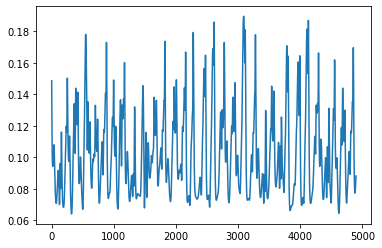

In [15]:
plt.plot(np.std(b.state.T, axis=0))

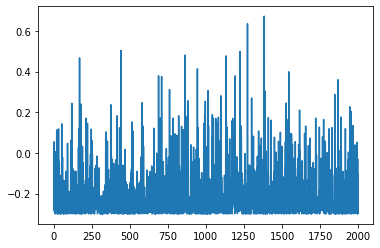

In [9]:
plt.plot(b.state.T)

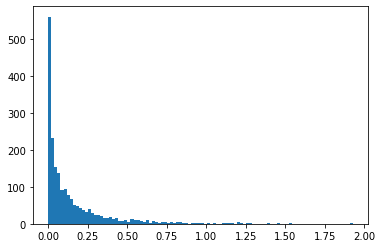

In [6]:
plt.hist(b.xx.T, bins=100);

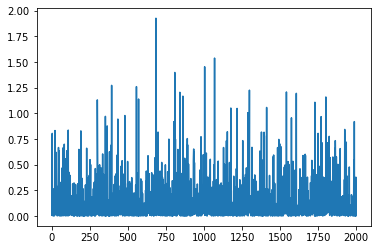

In [7]:
plt.plot(b.xx.T)

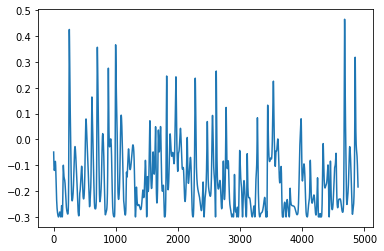

In [17]:
plt.plot(b.c[0, :, 1000])

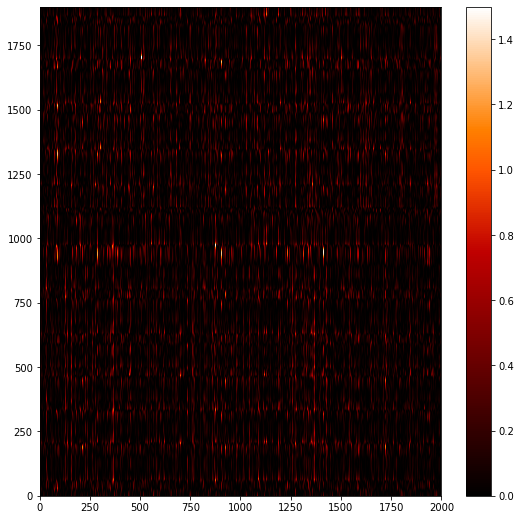

In [22]:
plt.figure(3,figsize=(9,9))
im=plt.pcolormesh(b.c[0, :, :-65], cmap='gist_heat')
plt.colorbar(im)

In [23]:
# testing data
ks_data_test = ks_data_origin[:, n_train:, :]

# Algorithm testing
parallel = 20
b.forget = n_test - b.pred_horizon*b.rec_pred_steps - parallel
pred_output, rmse, rmse_vec, rmse_vert = b.predict_and_score(ks_data_test, detailed_score=True)

Reservoir Computing algorithm - Testing phase:

Initialization complete. 		Elapsed time: 0.0003705024719238281 s


true_output.shape = (20, 29900)
Reservoir iterations complete. 		Elapsed time: 6.059807777404785 s
Testing complete. 			Elapsed time: 0.009049654006958008 s
Testing score: 0.0029588738046240973


best plot is at 13


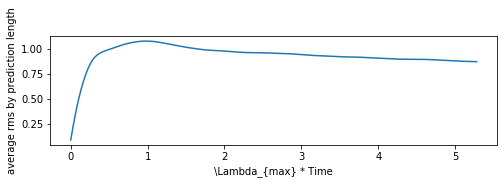

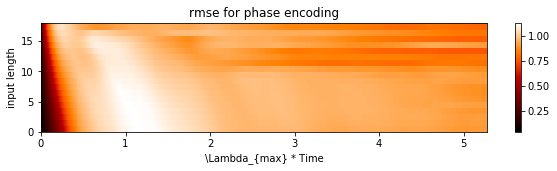

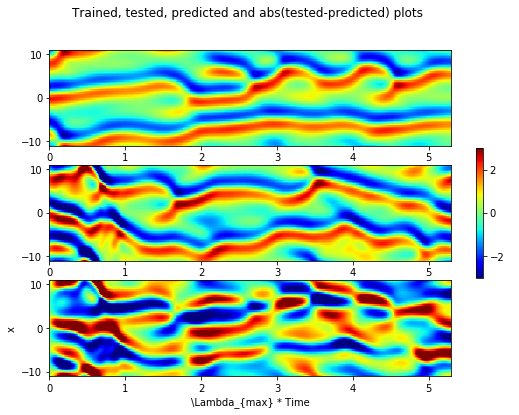

In [24]:
total_pred = (rmse.shape[1])
length_input = pred_output.shape[0] - total_pred
time_input = range(rmse.shape[0])
time_pred = tt[0:total_pred]*lyap_exp

plt.figure(1,figsize=(8,2))
plt.ylabel('average rms by prediction length')
plt.xlabel('\Lambda_{max} * Time')
plt.plot(time_pred[:], rmse_vec[:])
# scipy.io.savemat('time_pred_new_2.mat', dict(time_pred_new_2=time_pred))
# scipy.io.savemat('rmse_vec_new_2.mat', dict(rmse_vec_new_2=rmse_vec))
plt.show;
plt.savefig('intensity_SLM_kuramoto_rmse.png', dpi=400)

plt.figure(2,figsize=(10,2))
plt.title('rmse for phase encoding')
plt.ylabel('input length')
plt.xlabel('\Lambda_{max} * Time')
im=plt.pcolormesh(time_pred[:], time_input[:], rmse[:,:], cmap='gist_heat')
plt.colorbar(im)
plt.show;

xx = xx_
n_input = np.argmin(np.mean(rmse[:,:450],axis=1)) # np.argmin(rmse_vert)
# i=0
# time = (tt[0:n_input] if i==0 else tt[0:total_pred])*lyap_exp
# total_pred = b.pred_horizon*b.rec_pred_steps
total_pred = b.rec_pred_steps
# print(total_pred)

input_data = ks_data_test[0, b.forget:b.forget+total_pred, :]
targetted_data = ks_data_test[0, n_input+b.forget:n_input+b.forget+total_pred, :]

prediction = pred_output[n_input, :].reshape(targetted_data.shape)

vmax = max(abs(np.concatenate((targetted_data,input_data)).flatten()))
vmin = -vmax

# plot training data
fig, axs = plt.subplots(3, 1, sharex=False, figsize=(9,6))
plt.suptitle('Trained, tested, predicted and abs(tested-predicted) plots                       ')
plt.ylabel('x')
plt.xlabel('\Lambda_{max} * Time')
# print(targetted_data.shape)
# print(prediction.shape)
# datum = [input_data, targetted_data, prediction, np.abs(targetted_data-prediction)]
datum = [targetted_data, prediction, targetted_data-prediction]
# print(datum[0].shape)
# time = (tt[0:n_input+b.forget] if i==0 else tt[0:total_pred])*lyap_exp
# xx_axs, time_axs = np.mgrid[xx, time]
xx_axs = np.zeros((spatial_points, total_pred))
time_axs = np.zeros((spatial_points, total_pred))
for i in range(total_pred):
    xx_axs[:, i] = xx
for i in range(spatial_points):
    time_axs[i, :] = (tt[n_input+b.forget:n_input+b.forget+total_pred]-tt[n_input+b.forget])*lyap_exp
for i in range(3):
    # im=axs[i].pcolormesh(time, xx, datum[i].T, cmap='viridis', vmin=vmin, vmax=vmax)
    im=axs[i].pcolormesh(time_axs, xx_axs, datum[i].T, cmap=plt.get_cmap('jet'), vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.4)
plt.savefig('intensity_SLM_kuramoto_prediction.png', dpi=400)

# plt.figure(3,figsize=(9,2.5))
# im=plt.pcolormesh(time_axs, xx_axs, datum[2].T, cmap='gray')
# plt.colorbar(im)
# # plt.savefig('DND_input_data.png')

print('best plot is at '+str(np.argmin(rmse_vert)))